In [1]:
import pandas as pd
import numpy as np
import pickle
# Read the Pickle file
ft8_data=pickle.load(open("Myft8Spots.pkl","rb"))
# Cheery pick just the propery dictionary from the GeoJSON data
qso=[n['properties'] for n in dict(ft8_data)['features']]
# Make a small data frame
df=pd.DataFrame.from_records(qso)

In [2]:
df.head()

,band,call,when,distance,heading
0,40,JP7RTJ,10,3342.228670,32.070216
1,20,BG7BDB,10,1784.337242,334.593156
2,40,YE0TUR,10,2850.978689,213.300844
3,20,BD7BS,10,1784.337242,334.593156
4,20,BH8PHG,10,1979.938553,316.099033


# Opps - TimeZone 

At the moment this is in UTC .... so we will just add 8 hours on to it

In [3]:
df['when']=df.when.apply(lambda x: (x+8)%24)

# Remove the non Contest Bands

In [4]:
df=df.query('band != 12').query('band != 18').query('band !=30')

# See how much traffic band per hour

We would expect the lower bands to be better during darkness.

In [5]:
df_band_hour = pd.DataFrame(df.groupby(['band','when'])['call'].size().to_frame('traffic'))

In [6]:
df_band_hour.replace(np.NaN,0,inplace=True)
df_band_hour.reset_index(inplace=True)
df_band_hour.head()

,band,when,traffic
0,10,0,58
1,10,1,62
2,10,2,90
3,10,3,137
4,10,4,89


# Lets Graph this 

The first is per Band - 1 graph each

In [7]:
import matplotlib.pyplot as plt 

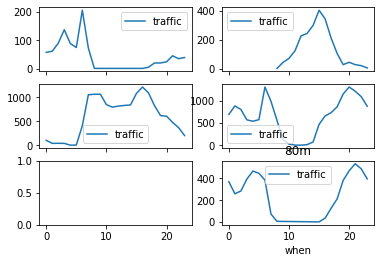

In [8]:
fig, axs = plt.subplots(3,2,sharex=True)
df_band_hour[df_band_hour.band==10].plot(x='when', y='traffic',kind='line', ax=axs[0,0])
plt.title('10m')
df_band_hour[df_band_hour.band==15].plot(x='when', y='traffic',kind='line', ax=axs[0,1])
plt.title('15m')
df_band_hour[df_band_hour.band==20].plot(x='when', y='traffic',kind='line',ax=axs[1,0])
plt.title('20m')
df_band_hour[df_band_hour.band==40].plot(x='when', y='traffic',kind='line', ax=axs[1,1])
plt.title('40m')
df_band_hour[df_band_hour.band==80].plot(x='when', y='traffic',kind='line', ax=axs[2,1])
plt.title('80m')
plt.show()




# Now we will combine the graphs

I think this is easier to read.

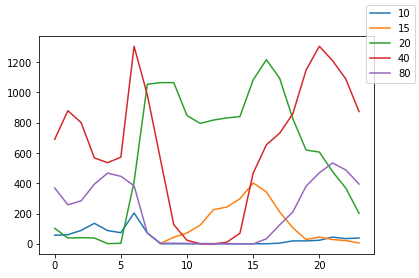

In [9]:
fig = plt.figure()
bands=[10,15,20,40,80]
for b in bands:
    tmp=df_band_hour[df_band_hour.band==b]
    plt.plot(tmp['when'], tmp['traffic'],label=f"{b}m")
fig.legend(bands)

# Band Summary

In [10]:
df.groupby(['band'])['call'].size().to_frame('traffic')

,traffic
band,
10,988
15,2219
20,14459
40,15475
80,5334


# It would be nice to know which continent the stations we are hearing are coming from

In order to do this, I need to use an existing module I wrote, and to extract this data.

In [11]:
from ham import dxcc
dx = dxcc.DxccAll()

want to open /Users/tim/pe38/lib/python3.8/site-packages/ham/dxcc/data/cty.dat


In [12]:
country = dx.find('M0FGC')
print(f"Country is {country.Country_Name} Continent is  {country.Continent_Abbreviation}")

Country is England Continent is  EU


# So now add 2 columns for these items


In [13]:
df['Country']=df.call.apply(lambda x: dx.find(x).Country_Name)
df['Continent']=df.call.apply(lambda x: dx.find(x).Continent_Abbreviation)

# Summary Continents

This should be a simple query now

In [14]:
df.head()

,band,call,when,distance,heading,Country,Continent
0,40,JP7RTJ,18,3342.228670,32.070216,Japan,AS
1,20,BG7BDB,18,1784.337242,334.593156,China,AS
2,40,YE0TUR,18,2850.978689,213.300844,Indonesia,OC
3,20,BD7BS,18,1784.337242,334.593156,China,AS
4,20,BH8PHG,18,1979.938553,316.099033,China,AS


In [15]:
df.groupby(['Continent'])['when'].size().to_frame('traffic')

,traffic
Continent,
AF,52
AS,29424
EU,1664
NA,360
OC,6864
SA,111


As usual traffic from Africa and South America are quite rare.

But now we can produce a chart - showing when the best time to try and get traffic from a continent will be

In [16]:
df_time_bands=df.groupby(['Continent','band','when'])['call'].size().to_frame('traffic').unstack().replace(np.NaN,0)
df_time_bands

traffic                                                    \
when                0      1      2      3      4      5       6      7    
Continent band                                                             
AF        10       0.0    1.0    1.0    0.0    3.0    0.0     0.0    3.0   
          20       3.0    9.0    1.0    0.0    0.0    0.0     0.0    0.0   
          80       0.0    1.0    0.0    0.0    0.0    0.0     8.0    0.0   
AS        10      47.0   51.0   45.0   57.0   23.0   16.0    48.0   42.0   
          15       0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
          20      32.0    7.0   21.0   27.0    3.0    0.0   351.0  908.0   
          40     415.0  564.0  601.0  469.0  453.0  528.0  1141.0  745.0   
          80     314.0  179.0  210.0  241.0  379.0  402.0   269.0   61.0   
EU        10       8.0    9.0   39.0   80.0   61.0   54.0   144.0   22.0   
          15       0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
          20       0.0    0.0    0.0    4.0    0.0    0.0     0.0    0.0   
          40       7.0   24.0   49.0   66.0   50.0   13.0    39.0    3.0   
          80      10.0   20.0   36.0  109.0   65.0   13.0    62.0    5.0   
NA        10       1.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
          20       0.0    0.0    0.0    0.0    0.0    0.0     9.0   16.0   
          40      39.0   10.0    1.0    0.0    0.0    0.0     0.0    0.0   
          80       0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
OC        10       2.0    1.0    5.0    0.0    1.0    3.0     3.0    5.0   
          15       0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
          20      68.0   16.0    0.0    0.0    0.0    2.0    47.0  128.0   
          40     230.0  282.0  150.0   33.0   29.0   24.0   104.0  233.0   
          80      46.0   59.0   39.0   45.0   24.0   31.0    39.0    7.0   
SA        10       0.0    0.0    0.0    0.0    1.0    2.0    10.0    1.0   
          15       0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0   
          20       1.0    8.0   20.0    9.0    0.0    3.0     3.0    2.0   
          40       0.0    0.0    0.0    0.0    5.0    8.0    21.0    4.0   
          80       0.0    0.0    0.0    0.0    0.0    1.0     7.0    0.0   

                              ...                                              \
when               8      9   ...     14      15      16     17     18     19   
Continent band                ...                                               
AF        10      0.0    0.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
          20      0.0    0.0  ...    0.0     1.0     0.0    0.0    0.0    0.0   
          80      0.0    0.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
AS        10      2.0    0.0  ...    0.0     0.0     0.0    1.0    5.0   15.0   
          15      4.0   43.0  ...  281.0   339.0   281.0  165.0   86.0   19.0   
          20    856.0  933.0  ...  809.0  1021.0  1115.0  871.0  622.0  370.0   
          40    424.0  121.0  ...   70.0   460.0   628.0  616.0  520.0  747.0   
          80      6.0    0.0  ...    0.0     1.0    35.0  117.0  204.0  319.0   
EU        10      0.0    0.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
          15      0.0    0.0  ...    0.0     2.0     2.0    1.0    9.0    0.0   
          20      0.0    0.0  ...    0.0     3.0     6.0    8.0   37.0  122.0   
          40      0.0    0.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
          80      0.0    0.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
NA        10      0.0    0.0  ...    0.0     0.0     1.0    1.0    5.0    4.0   
          20      3.0    1.0  ...    0.0     0.0     0.0    0.0    0.0    0.0   
          40      0.0    0.0  ...    0.0     0.0     2.0    0.0    0.0    0.0   
          80      0.0    0.0  ...    0.0     0.0     0.0    1.0    0.0    2.0   
OC        10      0.0    0.0  ...    0.0     0.0     1.0    4.0   11.0    2.0   
          15      0.0    2.0  ...

# Lets look at this as a heat-map
These can be quite interesting to view.

As the previous data-frame is Just about what I think I need. Lets take the defaulkts

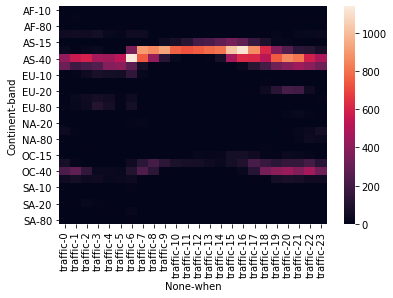

In [17]:
import seaborn
seaborn.heatmap(df_time_bands)

I find this difficult to read/understand. 

So I need to make some adjustments.

If I can average 50 QSO's (Contacts) an hour - I am usually a happy contester. So Let me put an upper limit of 30 into the heatmap. I do this to highlight some of the AF and SA values.


Try and think of this plot - like the visual spectrum from an FFT plot - with intensity going from Blue to Red. 

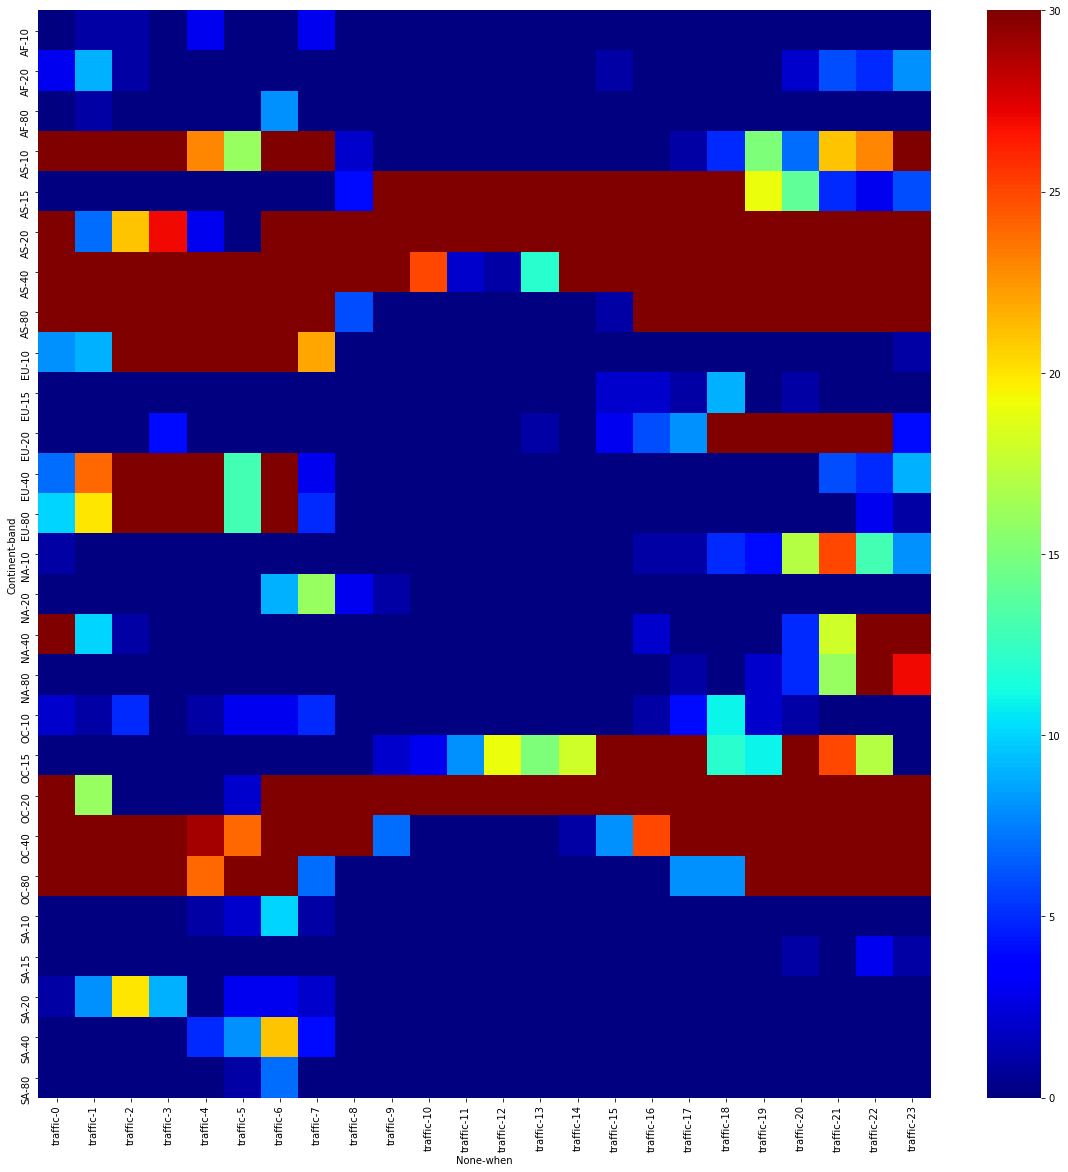

In [23]:
fig, ax = plt.subplots(figsize=(20,20))   
seaborn.heatmap(df_time_bands, vmin=0, vmax=30,cmap="jet",xticklabels=1,yticklabels=1,ax=ax)

In [19]:
# When can I work the UK ?

In [20]:
df[df.Country=='England'].groupby(['Continent','band','when'])['call'].size().to_frame('traffic').unstack().replace(np.NaN,0)

traffic                                    
when                1    2     3    4    5    6    18   20
Continent band                                            
EU        10       0.0  2.0  12.0  9.0  6.0  2.0  0.0  0.0
          20       0.0  0.0   0.0  0.0  0.0  0.0  1.0  1.0
          80       1.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
# And the US

In [22]:
df[df.Country=='United States'].groupby(['Continent','band','when'])['call'].size().to_frame('traffic').unstack().replace(np.NaN,0)

traffic                                                      \
when                0    1    6     7    8    9    16   17   18   19    20   
Continent band                                                               
NA        10       1.0  0.0  0.0   0.0  0.0  0.0  1.0  1.0  5.0  4.0  17.0   
          20       0.0  0.0  7.0  15.0  3.0  1.0  0.0  0.0  0.0  0.0   0.0   
          40      32.0  7.0  0.0   0.0  0.0  0.0  2.0  0.0  0.0  0.0   5.0   
          80       0.0  0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0  2.0   5.0   

                                  
when              21    22    23  
Continent band                    
NA        10    25.0  13.0   8.0  
          20     0.0   0.0   0.0  
          40    18.0  31.0  63.0  
          80    16.0  36.0  21.0